# Identification
Please indicate your name

Student 1: Andrei Aralov

Student 2: Andrea Cosentino

# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.ndimage import rotate, affine_transform


# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
from scipy.signal import convolve2d
def conv2d(a, b):
    return convolve2d(a, b, mode='same')

def SobelDirs(I):
    sx = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1],
    ])
    gx = conv2d(I, sx)
    
    sy = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    gy = conv2d(I, sy)
    
    return gx, gy

def SobelDetector(I, s):
    """ Array*double -> Array """
    gx, gy = SobelDirs(I)
    r = np.sqrt(gx**2 + gy**2)
    return r > s

def optimalSigma(n):
    return ( n - 1 ) / 6

def computeR(I, scale, kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Ix, Iy = SobelDirs(I)
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy
    
    sigma = optimalSigma(scale)
    s = gaussianKernel(sigma)
    
    Ix2 = conv2d(Ix2, s)
    Iy2 = conv2d(Iy2, s)
    Ixy = conv2d(Ixy, s)
    D = Ix2 * Iy2 - Ixy * Ixy
    Tr = Ix2 + Iy2
    return D - kappa * Tr*Tr
    

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

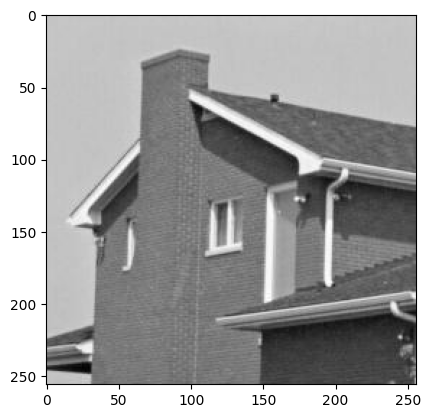

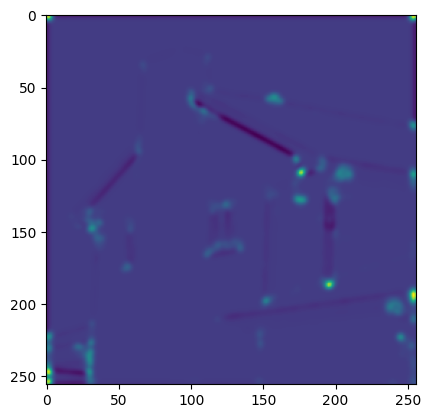

In [3]:
img = Image.open('img/house2.png')

plt.imshow(img)
plt.show()

R = computeR(img, 15, 0.04)
plt.imshow(R)
plt.show()

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

**Answer**:
We are classifying pixels into 3 categories:
1. Corners where both gradients Ix and Iy are large (giving large positive response)
2. Flat areas, where both gradients Ix and Iy are small (giving response which has small modulus)
3. Edges where either Ix is large and Iy is small or Ix is small and Iy is large (giving negative response which has large modulus).

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [4]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return R > thres

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [5]:
def rnms(R, Rbin):
    """ Array**2 -> Array """
    assert(R.shape == Rbin.shape)
    res = np.zeros_like(R)
    for i in range(1, R.shape[0] - 1):
        for j in range(1, R.shape[1] - 1):
            if Rbin[i, j] > 0:
                neigh = R[i - 1 : i + 2, j - 1 : j + 2]
                if np.all(R[i, j] >= neigh):
                    res[i, j] = 1
    return res

######## BONUS ##############


def rnmsROLL(image_harris, binarize):
    """ Array[n, m] -> Array[n, m] 
    """

    above = np.roll(image_harris, shift=-1, axis=0)
    below = np.roll(image_harris, shift=1, axis=0)
    left = np.roll(image_harris, shift=-1, axis=1)
    right = np.roll(image_harris, shift=1, axis=1)
    above_left = np.roll(above, shift=-1, axis=1)
    above_right = np.roll(above, shift=1, axis=1)
    below_left = np.roll(below, shift=-1, axis=1)
    below_right = np.roll(below, shift=1, axis=1)

    O = (image_harris>above) & (image_harris>below) & (image_harris>left) & (image_harris>right) & (
                image_harris>above_left) & (image_harris>above_right) & (image_harris>below_left) & (
                    image_harris>below_right)
    return np.where(binarize==1, O, 0)


3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [6]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, sigma, kappa)
    R_th = thresholdR(R, thres)
    R_nms = rnms(R, R_th)
    return R_nms

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

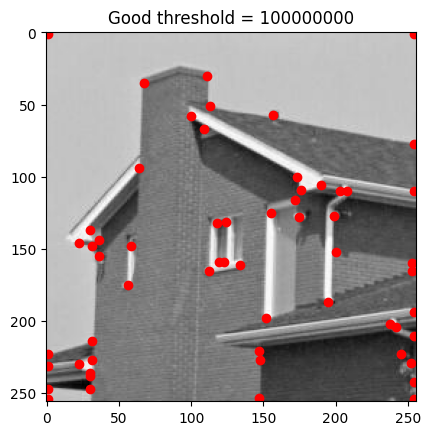

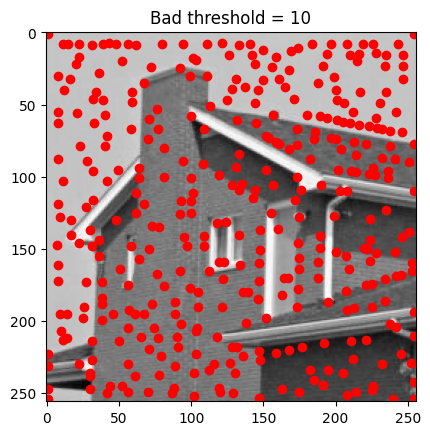

In [7]:
def displayCorners(corners):
    x, y = np.nonzero(corners)
    plt.scatter(y, x, color='red')
    plt.show()

t1 = 100000000
plt.title(f'Good threshold = {t1}')
corners = cornerDetector(img, 15, 0.04, t1)
plt.imshow(img)
displayCorners(corners)

t2 = 10
plt.title(f'Bad threshold = {t2}')
corners = cornerDetector(img, 15, 0.04, t2)
plt.imshow(img)
displayCorners(corners)


5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

**Answer**: It's able to detect the corners fairly good given that we choose right threshold value.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

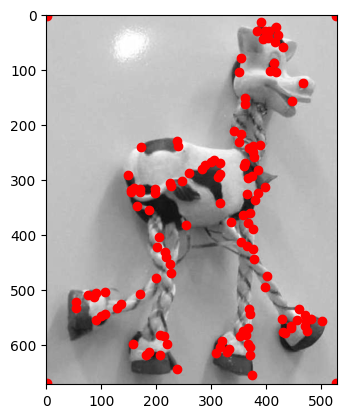

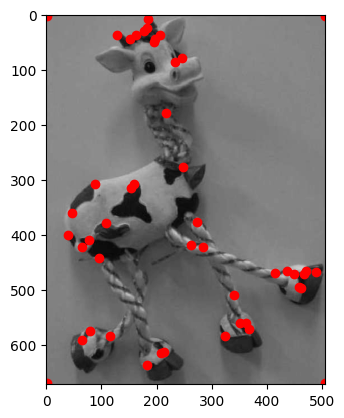

dynamic range of the first image: (np.uint8(1), np.uint8(255))
dynamic range of the second image: (np.uint8(0), np.uint8(253))


In [17]:
def detectAndShow(img, scale, threshold):
    corners = cornerDetector(img, scale, 0.04, threshold)
    plt.imshow(img, cmap='grey')
    displayCorners(corners)


t = t1
img1 = np.asarray(Image.open('img/toyHorse1.png'))
detectAndShow(img1, 15, t)

img2 = np.asarray(Image.open('img/toyHorse2.png'))
detectAndShow(img2, 15, t)


dynamicRange1 = img1.min(), img1.max()
dynamicRange2 = img2.min(), img2.max()

print(f'dynamic range of the first image: {dynamicRange1}')
print(f'dynamic range of the second image: {dynamicRange2}')


2) What are the dynamic ranges of these two images ?

**Answer**: [1; 255] and [0; 253]

3) What are the transformations beetween the two images ?

**Answer**: it looks like a projective (also called homography) transformation caused by a different view angle

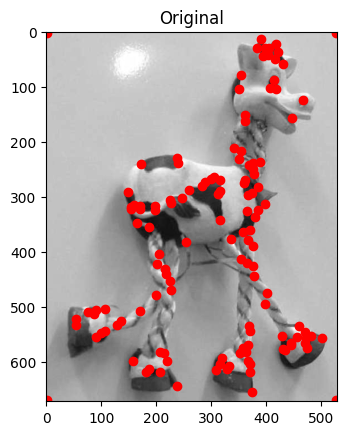

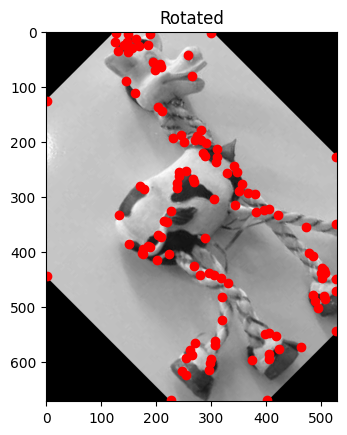

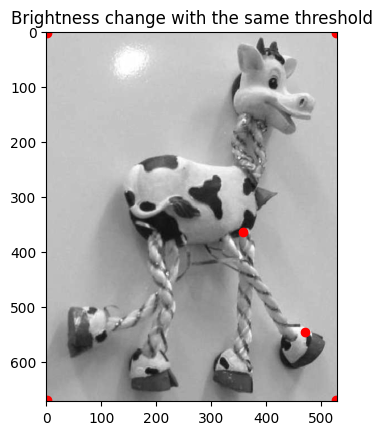

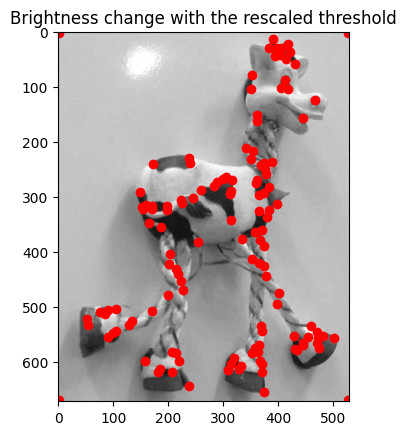

In [24]:
from scipy.ndimage import affine_transform

# def get_rotation_mat(angle, shape):
#     s_m = np.array([[1, 0, 0, shape[-3] / 2],
#                 [0, 1, 0, shape[-2] / 2],
#                 [0, 0, 1, shape[-1] / 2],
#                 [0, 0, 0, 1]])
#     r = R.from_euler('xyz', angle, degrees=True).as_matrix()
#     r_full = np.zeros_like(s_m)
#     r_full[:3, :3] = r
#     r_full[-1, -1] = 1
#     r_full = s_m @ r_full @ np.linalg.inv(s_m)
#     return r_full

def get_rot_mat(a, shape):
    rot_mat = np.asarray([
        [np.cos(a), np.sin(a), 0],
        [-np.sin(a), np.cos(a), 0],
        [0, 0, 1]
    ])
    t_mat = np.asarray([
        [1, 0, shape[0] // 2],
        [0, 1, shape[1] // 2],
        [0, 0, 1]
    ])
    
    return t_mat @ rot_mat @ np.linalg.inv(t_mat)

def rotate_img(img, a):
    return affine_transform(img, get_rot_mat(a, img.shape))


plt.title('Original')
detectAndShow(img1, 15, t)
plt.title('Rotated')
detectAndShow(rotate_img(img1, np.pi / 4), 15, t)
plt.title('Brightness change with the same threshold')
detectAndShow(img1 * 0.5, 15, t)
plt.title('Brightness change with the rescaled threshold')
detectAndShow(img1 * 0.5, 15, t * (0.5 ** 4))

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

**Answer**:
1) It is rotation-invariant
2) When using the same threshold, it is invariant to affine transformation of brightness. But we could rescale the threshold by the factor of scaling brightness to the power of 4: if $I' = \alpha I + \beta$ and $t$ is the threshold for $I$, then $t' = \alpha^4 t$ -- is the threshold for $I'$ which gives the same corners.